In [116]:
#Samuel Ghebreyesus
#11/12/2022

%pylab inline

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from mlxtend.evaluate import bias_variance_decomp
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\samgh\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy



In [117]:
# read in csv file dataset
import pandas as pd
df = pd.read_csv("C:/Users/samgh/Downloads/heart.csv")

In [118]:
# get preview of dataset
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [119]:
# check for any missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


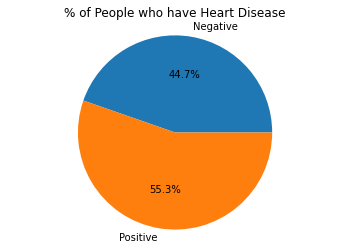

In [120]:
#check how balanced the dataset is. we see that it is pretty balanced with about a 55-45 split on having heart disease 
#versus not
from matplotlib import pyplot as plt
zero_count = (df['HeartDisease']==0).sum()
one_count = (df['HeartDisease']==1).sum()
heart_disease = [zero_count, one_count]
my_labels = 'Negative','Positive'
plt.pie(heart_disease,labels=my_labels,autopct='%1.1f%%')
plt.title('% of People who have Heart Disease')
plt.axis('equal')
plt.show()

In [121]:
# create histograms/bar graphs to visualize the data for both classes for each independent variable
# some observations:
# heart disease became more common the older the age 
# the majority of heart disease victims were men
# chest pain type ASY is much more likely to lead to heart disease 
# the majority of ST_Slope flat and ST_Slope Down were likely to have heart disease. 

import plotly.express as px
columns = ["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]
for x in columns:
    fig = px.histogram(df, x=x, color="HeartDisease")
    fig.show()

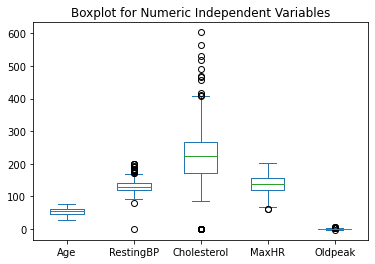

In [122]:
# made boxplot for numeric independent variables to see if there were any outliers
df[["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]].plot(kind="box", title="Boxplot for Numeric Independent Variables")
plt.show()

In [123]:
# tried to find data point where restingbp equals 0 because that is a nonsensical outlier data point for a living human
# being (restingBP has to be greater than 0 unless person is dead)
df[df["RestingBP"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [124]:
# tried to find data points where cholesterol equals 0 because that is a nonsensical outlier data point for a living human
# being
df[df["Cholesterol"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [125]:
# replaced outlier values of restingbp and cholesterol equal to zero with the median of those columns which is a much more 
# sensible value
df["RestingBP"]=df["RestingBP"].mask(df["RestingBP"]==0).fillna(df["RestingBP"].median())
df["Cholesterol"]=df["Cholesterol"].mask(df["Cholesterol"]==0).fillna(df["Cholesterol"].median())

In [126]:
# performed label encoding by going through each of the categorical values and transforming them to numeric values 
from sklearn.preprocessing import LabelEncoder
cat_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
for x in cat_columns:
    encoder=LabelEncoder()
    df[x]=encoder.fit_transform(df[x])        
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140.0,289.0,0,1,172,0,0.0,2,0
1,49,0,2,160.0,180.0,0,1,156,0,1.0,1,1
2,37,1,1,130.0,283.0,0,2,98,0,0.0,2,0
3,48,0,0,138.0,214.0,0,1,108,1,1.5,1,1
4,54,1,2,150.0,195.0,0,1,122,0,0.0,2,0


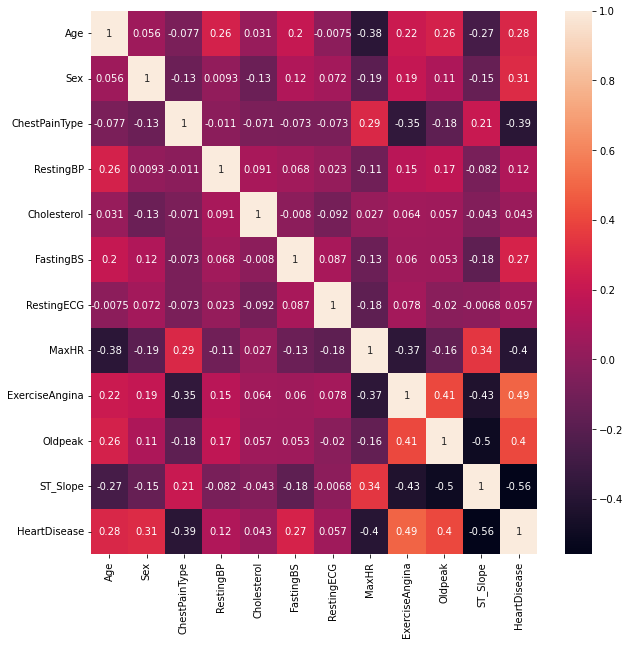

In [127]:
# created a correlation matrix to see which variables were strongly correlated positively or negatively to each other
# there is not really a super strong correlation between any variables (highest positive correlation is 0.49 and highest
# negative correlation is -0.56)
import seaborn as sns
plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(), annot=True)

In [128]:
# Cholesterol and RestingECG have correlations with heart disease less than 0.1 so very weak correlation. As a result,
# I removed those variables
df=df.drop(['Cholesterol','RestingECG'],axis=1)
df.head()

,Age,Sex,ChestPainType,RestingBP,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140.0,0,172,0,0.0,2,0
1,49,0,2,160.0,0,156,0,1.0,1,1
2,37,1,1,130.0,0,98,0,0.0,2,0
3,48,0,0,138.0,0,108,1,1.5,1,1
4,54,1,2,150.0,0,122,0,0.0,2,0


In [129]:
# performed pca on the data to reduce dimensionality and used standard scaling to standardize the values since there is 
# a wide range for the different variables. Used 8 principal components and put the reduced-dimension pca projected
# data into a dataframe 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
Y = df[['HeartDisease']]
X = df.drop(columns='HeartDisease')
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA(n_components=8)
pcs = pca.fit_transform(X, Y)
dfPcs = pd.DataFrame(data=pcs, columns=[('PC' + str(i)) for i in range(1,9)])
dfPca = pd.concat([dfPcs, df['HeartDisease']], axis=1)
dfPca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,HeartDisease
0,-2.161846,-0.368253,0.035131,0.067850,-1.247570,-0.888839,0.006290,-0.231107,0
1,-1.091542,1.847671,1.792889,0.334927,0.337836,-0.368294,-0.867762,-0.922420,1
2,-1.230061,-0.927605,-0.743703,-1.033548,-0.714881,0.405283,-1.106763,-0.947160,0
3,1.071847,-0.353556,1.638094,-1.048729,1.361666,-0.411511,-1.132365,-0.108123,1
4,-1.083662,1.110296,-0.487372,-0.757342,-1.325024,0.727883,-0.450382,-0.268133,0


In [130]:
# this tells us how much percent of the variance can be explained by the principal components. Goal is for it to be greater
# than 90%. If less than 90%, would increase the amount of principal components in the pca. 
sum(pca.explained_variance_ratio_)

0.9539214265862945

In [131]:
# performed pca on the training data to reduce dimensionality and used standard scaling to standardize the values since 
# there is a wide range for the different variables. Used 8 principal components and put the reduced-dimension pca projected
# data into a dataframe
train_df = pd.read_csv("C:/Users/samgh/Downloads/heart_train_718.csv")
train_df["RestingBP"]=train_df["RestingBP"].mask(train_df["RestingBP"]==0).fillna(train_df["RestingBP"].median())
train_df["Cholesterol"]=train_df["Cholesterol"].mask(train_df["Cholesterol"]==0).fillna(train_df["Cholesterol"].median())
encoder=LabelEncoder()
train_df['Sex']=encoder.fit_transform(train_df['Sex'])
train_df['ChestPainType']=encoder.fit_transform(train_df['ChestPainType'])
train_df['RestingECG']=encoder.fit_transform(train_df['RestingECG'])
train_df['ExerciseAngina']=encoder.fit_transform(train_df['ExerciseAngina'])
train_df['ST_Slope']=encoder.fit_transform(train_df['ST_Slope'])
train_df=train_df.drop(['Cholesterol','RestingECG'],axis=1)
Y_train = train_df[['HeartDisease']]
X_train = train_df.drop(columns='HeartDisease')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
pca = PCA(n_components=8)
pcs = pca.fit_transform(X_train, Y_train)
train_dfPcs = pd.DataFrame(data=pcs, columns=[('PC' + str(i)) for i in range(1,9)])
train_dfPca = pd.concat([train_dfPcs, train_df['HeartDisease']], axis=1)
train_dfPca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,HeartDisease
0,-0.940243,2.005032,1.200385,1.325914,-0.467960,0.780632,-0.159711,-0.192074,0
1,2.088611,0.275781,0.579997,-0.062284,1.084253,0.047871,-0.341012,0.312422,1
2,0.673042,0.798860,-0.489984,0.177489,1.292675,0.416996,-0.712548,-1.177860,1
3,1.898350,-0.112293,0.571685,-0.261412,0.562954,0.990827,0.566232,0.226381,1
4,-1.543415,2.309620,0.994241,-1.613105,1.366374,-2.130865,-0.656590,-0.126845,1


In [132]:
# performed pca on the testing data to reduce dimensionality and used standard scaling to standardize the values since 
# there is a wide range for the different variables. Used 8 principal components and put the reduced-dimension pca projected
# data into a dataframe
test_df = pd.read_csv("C:/Users/samgh/Downloads/heart_test_200.csv")
test_df["RestingBP"]=test_df["RestingBP"].mask(test_df["RestingBP"]==0).fillna(test_df["RestingBP"].median())
test_df["Cholesterol"]=test_df["Cholesterol"].mask(test_df["Cholesterol"]==0).fillna(test_df["Cholesterol"].median())
encoder=LabelEncoder()
test_df['Sex']=encoder.fit_transform(test_df['Sex'])
test_df['ChestPainType']=encoder.fit_transform(test_df['ChestPainType'])
test_df['RestingECG']=encoder.fit_transform(test_df['RestingECG'])
test_df['ExerciseAngina']=encoder.fit_transform(test_df['ExerciseAngina'])
test_df['ST_Slope']=encoder.fit_transform(test_df['ST_Slope'])
test_df=test_df.drop(['Cholesterol','RestingECG'],axis=1)
Y_test = test_df[['HeartDisease']]
X_test = test_df.drop(columns='HeartDisease')
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)
pca = PCA(n_components=8)
pcs = pca.fit_transform(X_test, Y_test)
test_dfPcs = pd.DataFrame(data=pcs, columns=[('PC' + str(i)) for i in range(1,9)])
test_dfPca = pd.concat([test_dfPcs, test_df['HeartDisease']], axis=1)
test_dfPca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,HeartDisease
0,2.203631,0.708821,-1.842875,-0.532132,0.258514,1.429170,0.877202,1.046981,1
1,-1.684362,-0.838978,0.609221,-0.015572,-2.009242,-0.955437,0.760216,0.605043,1
2,0.967902,-1.588932,0.334065,0.629304,-0.387101,-0.053065,-0.326620,-0.101432,1
3,1.384295,-0.296618,0.744710,-0.774848,-0.939088,-0.736637,-0.659026,-0.102521,1
4,1.970385,-0.550849,0.246664,0.547044,0.494850,-0.328411,0.784184,-0.560394,1


In [133]:
# this method takes in a classifier and prints out the accuracy, confusion matrix, f1 score, bias and variance
def printMetrics(classifier):
    print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
    plot_confusion_matrix(classifier, X_test, Y_test) 
    plt.show()
    print("f1_score:", f1_score(Y_test, y_pred))
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(classifier, X_train.values, Y_train.values, X_test.values, Y_test.values, loss='0-1_loss',random_seed=123)
    print('Bias: %.3f' % avg_bias)
    print('Variance: %.3f' % avg_var)

In [134]:
# this method takes in a classifier and plots out the ROC curve
def plotROC(classifier):
    baseline_probs = [0 for _ in range(len(Y_test))]
    clf_probs = classifier.predict_proba(X_test)
    clf_probs = clf_probs[:, 1]
    baseline_auc = roc_auc_score(Y_test, baseline_probs)
    clf_auc = roc_auc_score(Y_test, clf_probs)
    print('ROC AUC=%.3f' % (clf_auc))
    baseline_fpr, baseline_tpr, _ = roc_curve(Y_test, baseline_probs)
    clf_fpr, clf_tpr, _ = roc_curve(Y_test, clf_probs)
    f = pyplot.figure()
    f.set_figwidth(12)
    f.set_figheight(12)
    pyplot.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Random Classifier')
    pyplot.plot(clf_fpr, clf_tpr, marker='.', label=classifier)
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()

Accuracy: 0.82


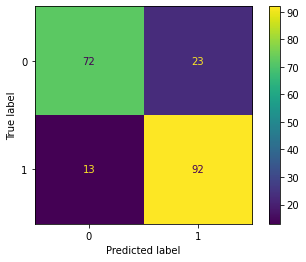

f1_score: 0.8363636363636364
Bias: 0.180
Variance: 0.046
ROC AUC=0.903


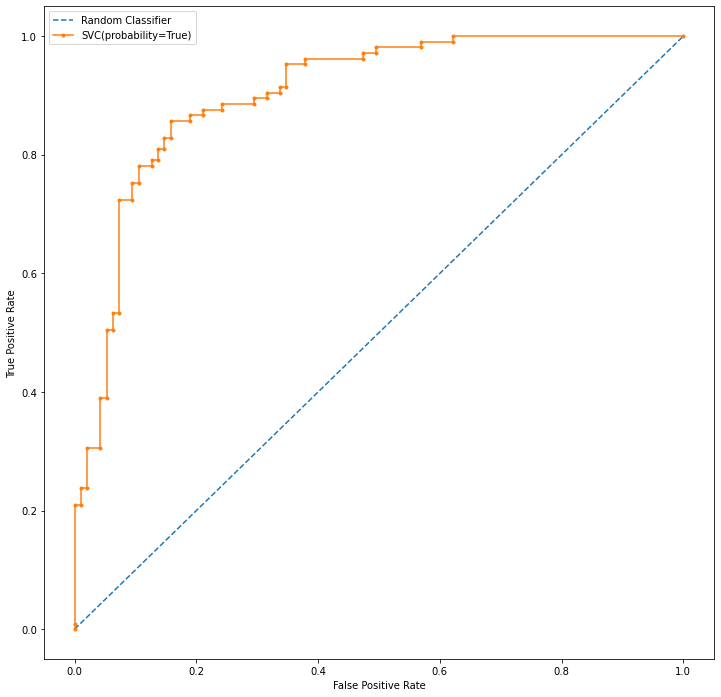

In [135]:
# Machine Learning Method #1: Support Vector Machine 
X_train = train_dfPca.drop(columns='HeartDisease')
Y_train = train_dfPca['HeartDisease']
X_test = test_dfPca.drop(columns='HeartDisease')
Y_test = test_dfPca['HeartDisease']
clf = svm.SVC(probability=True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
printMetrics(clf)
plotROC(clf)

Accuracy: 0.86


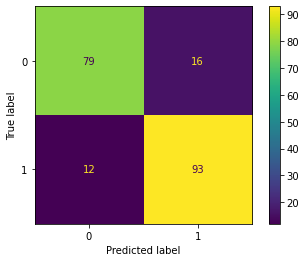

f1_score: 0.8691588785046729
Bias: 0.140
Variance: 0.040
ROC AUC=0.910


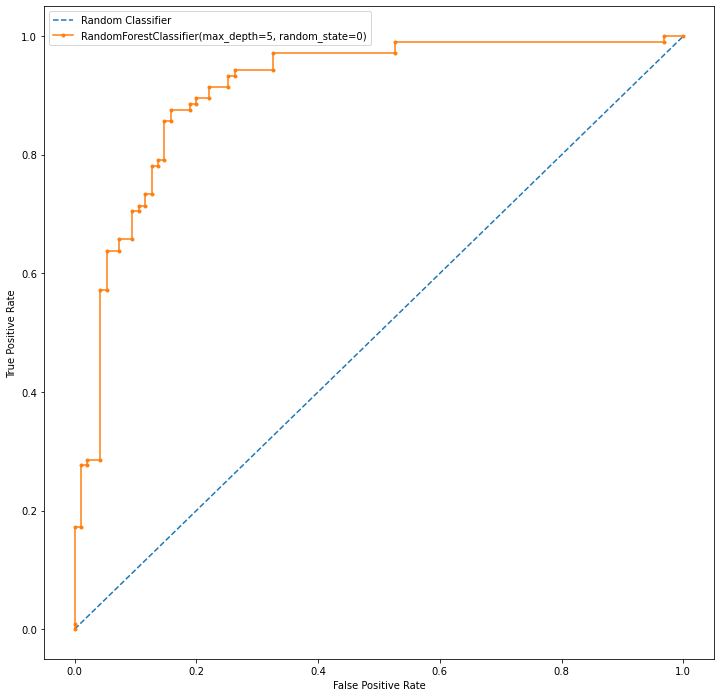

In [136]:
# Machine Learning Method #2: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 5, random_state = 0)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
printMetrics(rf)
plotROC(rf)

Accuracy: 0.85


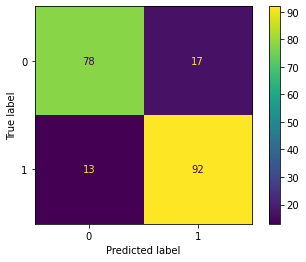

f1_score: 0.8598130841121495
Bias: 0.155
Variance: 0.053
ROC AUC=0.890


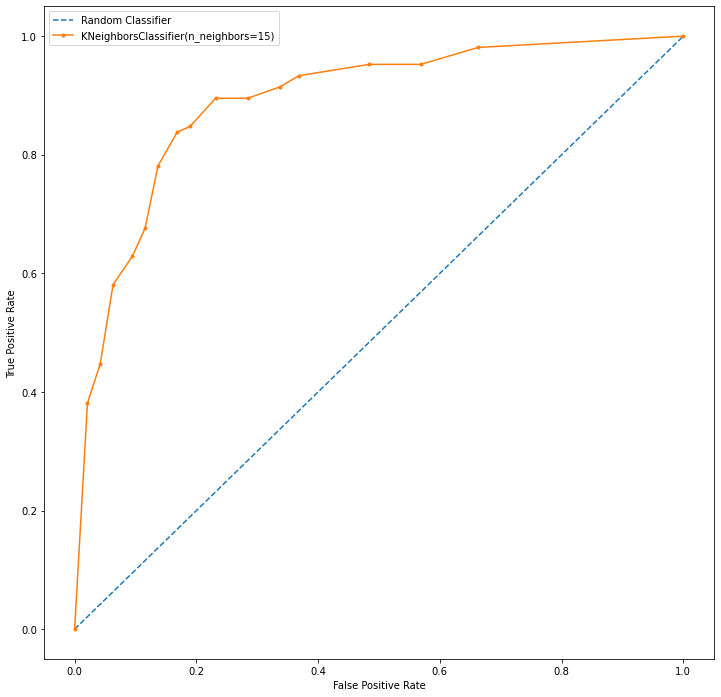

In [137]:
# Machine Learning Method #3: K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
printMetrics(knn)
plotROC(knn)

Accuracy: 0.82


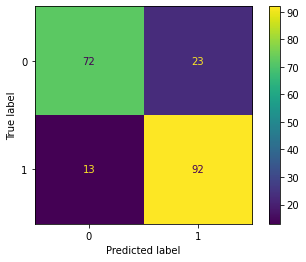

f1_score: 0.8363636363636364
Bias: 0.180
Variance: 0.026
ROC AUC=0.911


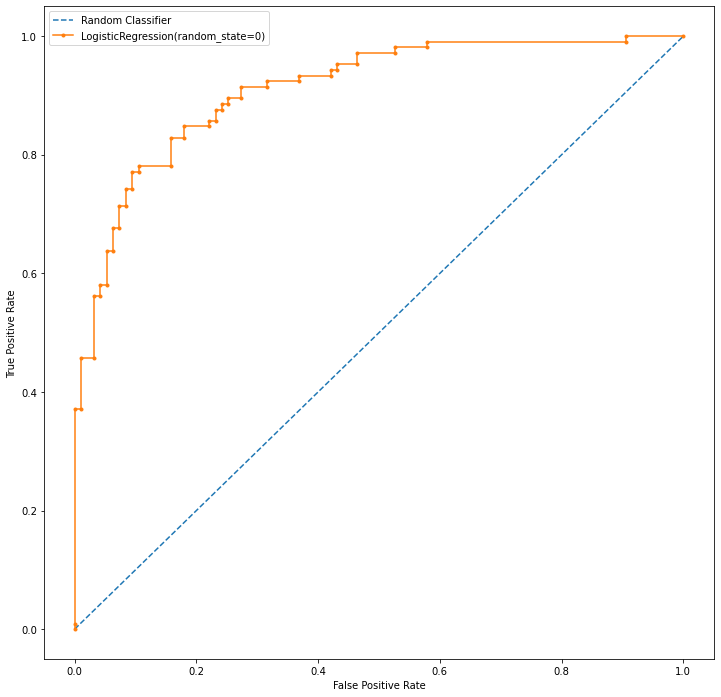

In [138]:
#Extension: Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)
printMetrics(lr)
plotROC(lr)

Accuracy: 0.86


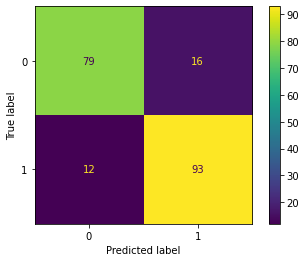

f1_score: 0.8691588785046729
Bias: 0.130
Variance: 0.084
ROC AUC=0.883


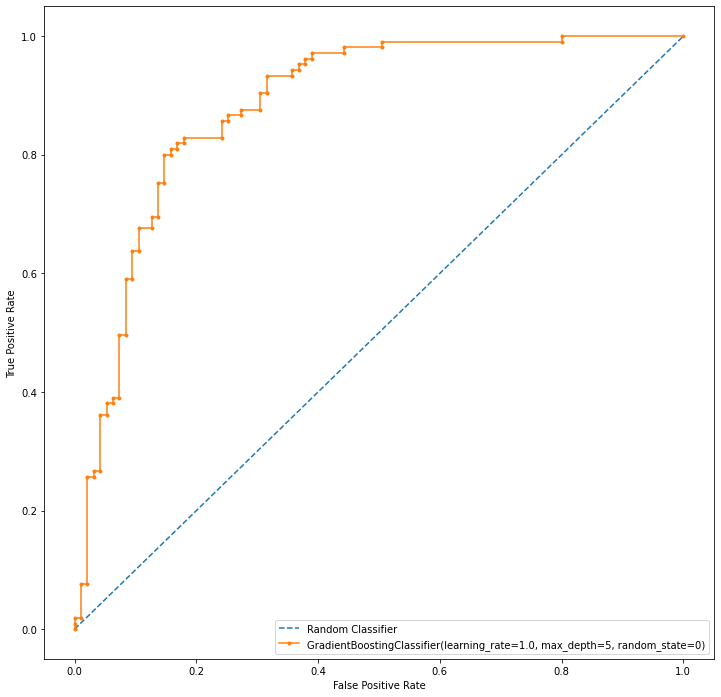

In [139]:
# Extension: Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
gbc.fit(X_train, Y_train)
y_pred = gbc.predict(X_test)
printMetrics(gbc)
plotROC(gbc)

Accuracy: 0.875


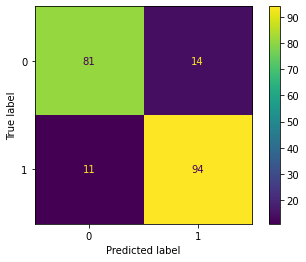

f1_score: 0.8826291079812207
Bias: 0.135
Variance: 0.042
ROC AUC=0.901


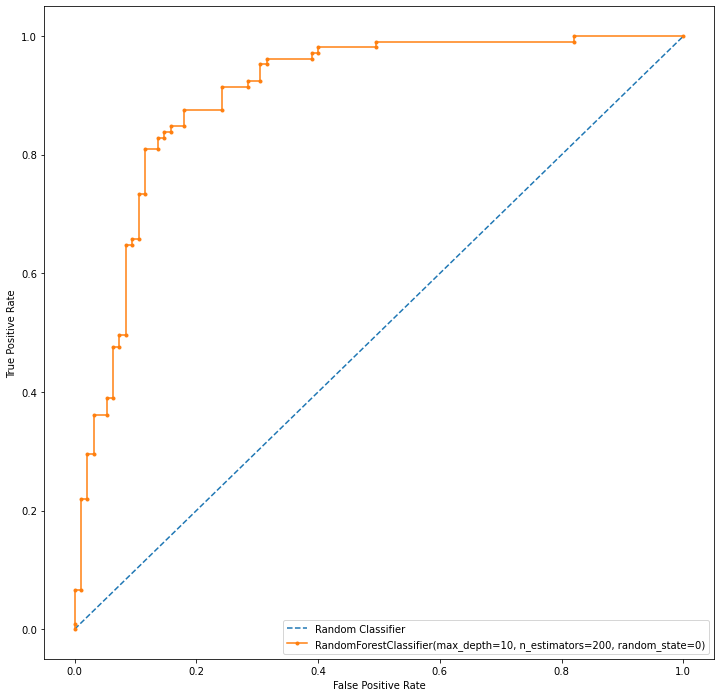

In [140]:
# Iteration 1: Changed the number of estimators from 100 to 200 and the max depth from 5 to 10
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, random_state = 0)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
printMetrics(rf)
plotROC(rf)

Accuracy: 0.86


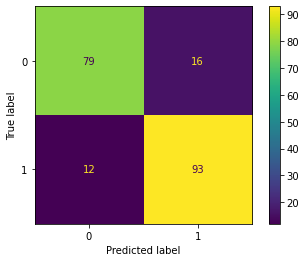

f1_score: 0.8691588785046729
Bias: 0.130
Variance: 0.044
ROC AUC=0.909


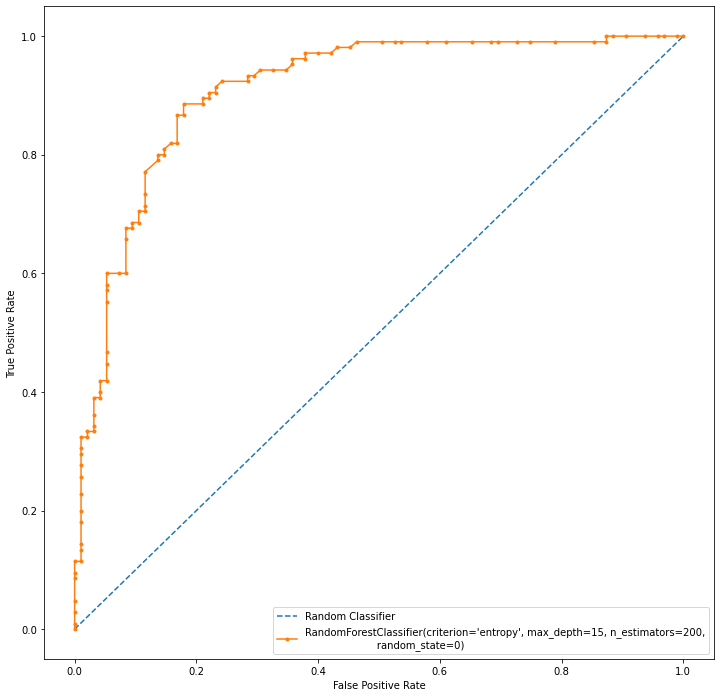

In [141]:
# Iteration #2: Changed criterion from default gini to entropy and increased the max depth to 15
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, criterion="entropy", max_depth = 15, random_state = 0)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
printMetrics(rf)
plotROC(rf)

Accuracy: 0.875


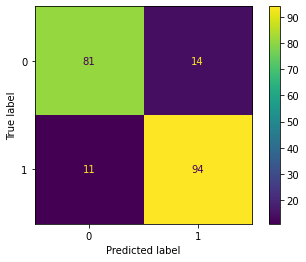

f1_score: 0.8826291079812207
Bias: 0.135
Variance: 0.047
ROC AUC=0.912


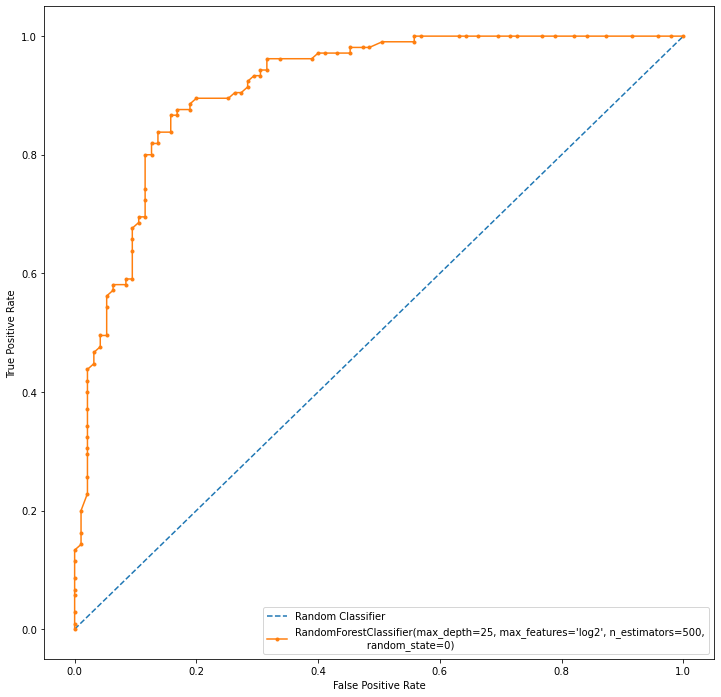

In [142]:
# Iteration #3: Changed the number of estimators to 500, max depth to 25, and max features to log2.
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500, max_depth = 25, max_features="log2", random_state = 0)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
printMetrics(rf)
plotROC(rf)

In [152]:
# Extension: Using GridSearchCV to attempt a bunch of additional iterations to make the system better for Random Forest
# Classifier. Performing Hyperparameter tuning 
from sklearn.model_selection import GridSearchCV

grid_param = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 25],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": range(2, 10, 1),
    "min_samples_leaf": range(1, 5, 1)
}

grid_search = GridSearchCV(estimator = rf, param_grid = grid_param, cv = 5, n_jobs = -1, verbose=3)

In [153]:
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=25, max_features='log2',
                                              min_samples_leaf=2,
                                              n_estimators=500,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 25],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10),
                         'n_estimators': [100, 200, 500]},
             verbose=3)

In [162]:
# finds the best parameters 
grid_search.best_params_

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

Accuracy: 0.885


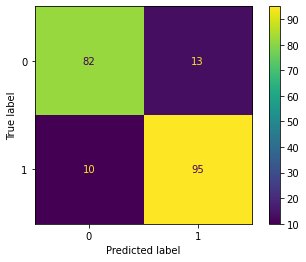

f1_score: 0.892018779342723
Bias: 0.135
Variance: 0.047
ROC AUC=0.907


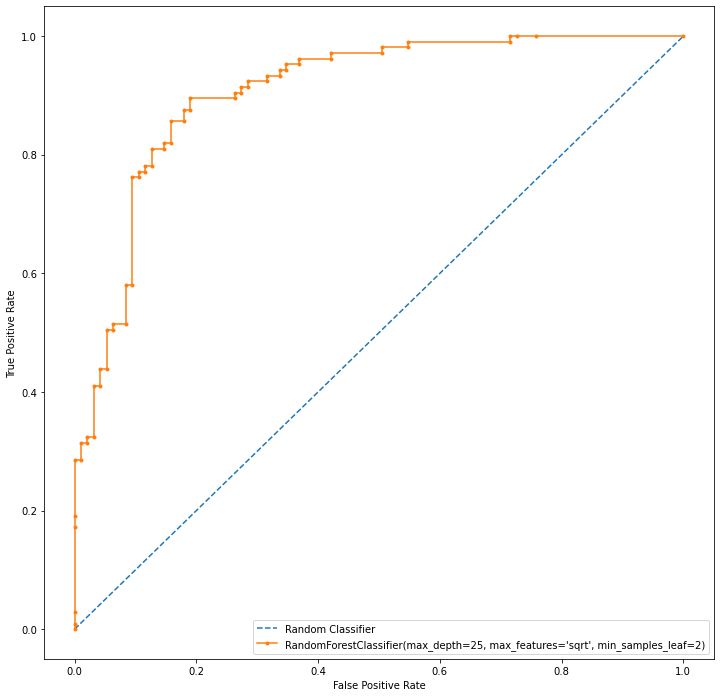

In [161]:
# implements random forest with the best parameters 
rf = RandomForestClassifier(max_depth=25, n_estimators=100, max_features="sqrt", min_samples_leaf=2, min_samples_split=2)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
printMetrics(rf)
plotROC(rf)